## Self Distillation test

In [1]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append("..") # Adds higher directory to python modules path.

import branching

from branching import branches
from branching import evaluate

# branching.enable_neptune(False)


In [2]:
train_ds, test_ds, validation_ds = branching.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 10,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [3]:
train_ds100, test_ds100, validation_ds100 = branching.dataset.prepare.dataset(tf.keras.datasets.cifar100.load_data(),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 100,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


### Define the Branch Model. this is a subclass of the standard Keras model and can do all the normal things

### Load the Datasets
<hr>
validation set is for eval during training, testing set is for eval after training

### make the loss function

In [2]:
from tensorflow.python.platform import tf_logging as logging
class _earlyStopping(keras.callbacks.EarlyStopping):
    def __init__(self,
               monitor='val_loss',
               min_delta=0,
               patience=0,
               verbose=0,
               mode='auto',
               baseline=None,
               restore_best_weights=False):
        self.monitor = monitor
        self.patience = patience
        self.verbose = verbose
        self.baseline = baseline
        self.min_delta = abs(min_delta)
        self.wait = 0
        self.stopped_epoch = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        # super(_earlyStopping, self).__init__(monitor=)
        if mode not in ['auto', 'min', 'max']:
            logging.warning('EarlyStopping mode %s is unknown, '
                          'fallback to auto mode.', mode)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
        elif mode == 'max':
            self.monitor_op = np.greater
        else:
            
            # if (self.monitor.endswith('acc') or self.monitor.endswith('accuracy') or self.monitor.endswith('auc')):
            self.monitor_op = np.greater
            # else:
                # self.monitor_op = np.less

        if self.monitor_op == np.greater:
            self.min_delta *= 1
        else:
            self.min_delta *= -1

        self.monitor_op = np.greater
        self.min_delta *= 1
        
    def get_monitor_value(self, logs):
        logs = logs or {}
        monitor_value = 0
        if type(self.monitor) is list:
            for i in self.monitor:
                _log_val = logs.get(i)
                # logging.warning("values are {}, {}".format(i,_log_val))
                if _log_val is None:
                    logging.warning('Metric `%s` '
                          'for early stopping is not available. Available metrics are: %s',
                          i, ','.join(list(logs.keys())))
                else:
                    monitor_value += _log_val
        # monitor_value = logs.get(self.monitor)
        if monitor_value is None:
            logging.warning('Early stopping conditioned on metric `%s` '
                          'which is not available. Available metrics are: %s',
                          self.monitor, ','.join(list(logs.keys())))
        return monitor_value


### define the branch structures

In [4]:
base_model = branching.Distill_BranchModel(name="./models/EfficientNetB0_Cifar10_tfkeras_Adam-0836_splitdata.hdf5")
base_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                            

In [34]:
new_model = tf.keras.models.load_model("./models/EfficientNetB0_Cifar10_tfkeras_Adam-0836_splitdata.hdf5")



In [35]:
model_name = "EfficientNetB0"
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(input_shape=(32,32,3),include_top=False, weights='imagenet', classes=10)
x = model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Flatten()
x = tf.keras.layers.Dense(10,activation="softmax",name="classification")(x)
model = tf.keras.models.Model(inputs=model.inputs, outputs=x)
model.set_weights(new_model.get_weights())

In [36]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 32, 32, 3)    0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 32, 32, 3)   7           ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 33, 33, 3)    0           ['normalization_1[0][0]']  

In [38]:
model.compile(loss=[trunk_loss], 
                  # optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
                  # optimizer="adam",
               metrics=['accuracy'])
model.evaluate(test_ds)

313/313 [==============================] - 6s 14ms/step - loss: 0.6873 - accuracy: 0.8360


[0.6873419880867004, 0.8360000252723694]

In [39]:
model.save("./models/EfficientNetB0_Cifar10_tfkeras_Adam-0836_splitdata_fixed.hdf5")

In [16]:
base_model.fit(train_ds,validation_data=test_ds,epochs=1)

Setting Main Layers  and branch layers training to true
https://app.neptune.ai/cailen01/self-distilation/e/SEL-26
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
1407/1407 [==============================] - 73s 52ms/step - loss: 0.0665 - accuracy: 0.9792 - val_loss: 0.0667 - val_accuracy: 0.9774
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 6 operations to synchronize with Neptune. Do not kill this process.


All 6 operations synced, thanks for waiting!


In [9]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                            

In [17]:
# trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# base_model.compile(loss=[trunk_loss], 
#                   # optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
#                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
#                   # optimizer="adam",
#                metrics=['accuracy'])
base_model.evaluate(test_ds)

313/313 [==============================] - 4s 14ms/step - loss: 0.6723 - accuracy: 0.8350


[0.6722943186759949, 0.8349999785423279]

In [10]:
# base_model.compile(loss=[trunk_loss], 
#                   optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
#                   # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
#                   # optimizer="adam",
#                metrics=['accuracy'])
# base_model.evaluate(test_ds)

In [5]:

class SelfDistilEndpoint(branches.branch.BranchEndpoint):
        """ distillation endpoint, performs the KL divergence between the teacher's and student's logits
    """
        def __init__(self, num_outputs, loss_coef=1.9, temperature=10, name=None, **kwargs):
            super(SelfDistilEndpoint, self).__init__(num_outputs=num_outputs, name=name)
            self.num_outputs = num_outputs
            self.loss_coef = loss_coef
            self.temperature = temperature 
            self.distillation_loss_fn=keras.losses.KLDivergence()

        def build(self, input_shape):
            tf.print("inputShape",input_shape)
            self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])
        
        def get_config(self):
            config = super().get_config().copy()
            config.update({
                'name': self.name
            })
            return config

        def call(self, inputs, teaching_distill=None):
            ''' do the normal kernel operations, then compare the difference between the teacher and this.
            '''
            outputs = tf.matmul(inputs,self.kernel)
            outputs_sm = tf.nn.softmax(outputs)
            # tf.print("outputs",outputs)
            # tf.print("teaching",teaching_distill)
            if teaching_distill is not None:
                distil_loss = self.distillation_loss_fn(outputs_sm/self.temperature, teaching_distill/self.temperature)
                distil_loss = distil_loss * self.loss_coef
                # print("KL_LOSS", kl_loss)
                # self.add_loss(kl_loss)
                self.add_loss(distil_loss)
                self.add_metric(distil_loss, aggregation='mean',name=self.name+"_distil") # metric so this loss value can be monitored.
            return outputs

In [6]:

def _branch_efficentNet(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ 
        Standard Branch, no distillation
        Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
    branchLayer = keras.layers.GlobalAveragePooling2D(name=tf.compat.v1.get_default_graph().unique_name("branch_pooling"),input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.Reshape(target_shape=(1,1,-1),name=tf.compat.v1.get_default_graph().unique_name("branch_reshape"),input_shape=(prevLayer.shape))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=380, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(branchLayer)
    # branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=1280, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    # branchLayer = layers.Dense(1280,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    output = keras.layers.Dense(10, activation='softmax', name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    return output

  

    
def _branch_Distill_Eff(prevLayer, teacher = None, teaching_features=None,targets=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.GlobalAveragePooling2D(name=tf.compat.v1.get_default_graph().unique_name("branch_pooling"),input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.Reshape(target_shape=(1,1,-1),name=tf.compat.v1.get_default_graph().unique_name("branch_reshape"),input_shape=(prevLayer.shape))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=380, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(branchLayer)
    # branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=1280, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    # branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    # branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    # branchLayer = layers.Dense(1280,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    # branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    # branchLayer = SelfDistilDense(512, loss_coef=1.9, temperature = 10, name=tf.compat.v1.get_default_graph().unique_name("branch_feature_student"))(branchLayer,teacher)
    # branchLayer = layers.ReLU()(branchLayer)
    # print(teacher)

    # output = SelfDistilEndpoint(num_outputs=10, loss_coef=1.9, temperature = 10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer,teacher)
    
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    return output



In [ ]:
# model2 = branching.BranchModel(name="./models/EfficientNetB0_Cifar10_tfkeras_Adam-0836_splitdata_fixed.hdf5", custom_objects={})
# model2.summary()
outputs = [model2.get_layer("classification").get_output_at(0)
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model2.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")

model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 32, 32, 3)    0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 32, 32, 3)   7           ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 33, 33, 3)    0           ['normalization_1[0][0]']  

### Branching version

In [7]:
tf.keras.backend.clear_session()
model = branching.BranchModel(name="./models/EfficientNetB0_Cifar10_tfkeras_Adam-0836_splitdata_fixed.hdf5", custom_objects={})

# model = branching.Distill_BranchModel(name="./models/EfficientNetB0_Cifar10_tfkeras.hdf5")
# model = branching.Distill_BranchModel(model=model)

### branch the model, no distillation
# model.add_branches([_branch_conv1,_branch_conv1],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           )

#efficientNet
# block2b_add, block3b_add 

# branch_loss = IAD_loss(growth_callback)
branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
### branch and distill the model
model.add_branches(
                  [_branch_efficentNet,_branch_efficentNet],
                  ["block2b_add",
                          "block5c_add"        ],
                  )

model.compile(loss=[trunk_loss, trunk_loss, trunk_loss], 
                  # optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
                  # optimizer="adam",
               metrics=['accuracy'])


# model2.summary()
# outputs = [ [model2.get_layer("branch_exit").get_output_at(0)],
#            # [model2.get_layer("branch_exit").get_output_at(0),model2.get_layer("classification").get_output_at(0)]
#             [model2.get_layer("branch_exit").get_output_at(0),model2.get_layer("branch_exit_1").get_output_at(0)],
#             [model2.get_layer("branch_exit").get_output_at(0),model2.get_layer("branch_exit_1").get_output_at(0),model2.get_layer("classification").get_output_at(0)]
#           ]
# from keras_flops import get_flops    
# for _outputs in outputs:
#     temp_model = tf.keras.models.Model(inputs=model2.inputs, outputs=_outputs)
#     # Calculae FLOPS
#     print(temp_model.outputs)
#     flops = get_flops(temp_model, batch_size=1)
#     print(f"FLOPS: {flops / 10 ** 9:.03} G")
    

Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  block2b_add
add Branch to branch point  block5c_add
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <branching.core.BranchModel object at 0x000002083BEBA888>


In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 32, 32, 3)    0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 32, 32, 3)   7           ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 33, 33, 3)    0           ['normalization_1[0][0]']  

In [28]:
model.save('./models/efficientNet_sgd_split_eff_adam_branching_next.hdf5')

In [27]:
outputs = [ [model_base.get_layer("branch_exit").get_output_at(0)],
           # [model2.get_layer("branch_exit").get_output_at(0),model2.get_layer("classification").get_output_at(0)]
            [model_base.get_layer("branch_exit").get_output_at(0),model_base.get_layer("branch_exit_1").get_output_at(0)],
            [model_base.get_layer("branch_exit").get_output_at(0),model_base.get_layer("branch_exit_1").get_output_at(0),model2.get_layer("classification").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model_base.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>]
FLOPS: 0.00447 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
FLOPS: 0.013 G


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'") at layer "rescaling_1". The following previous layers were accessed without issue: []

In [10]:
tags = ["branching","efficentNet","adam","e30","bp2,5"]
model.fit(train_ds, validation_data=validation_ds, epochs = 30,parameters=tags)

NameError: name 'earlyStop' is not defined

In [21]:
model.evaluate(test_ds)

313/313 [==============================] - 6s 17ms/step - loss: 2.3050 - classification_loss: 0.7145 - branch_exit_loss: 0.7805 - branch_exit_1_loss: 0.8100 - classification_accuracy: 0.8312 - branch_exit_accuracy: 0.7328 - branch_exit_1_accuracy: 0.8350


[2.304980993270874,
 0.7144927978515625,
 0.7805360555648804,
 0.809952974319458,
 0.8312000036239624,
 0.7328000068664551,
 0.8349999785423279]

In [13]:
model.save('./models/efficientNet_sgd_split_eff_sgd_branching_next.hdf5')

In [12]:
model.summary()

NameError: name 'model' is not defined

### branch self distillation
<hr>
The already existing model is loaded from the file, "*.hdf5", 


In [32]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()


# branch_loss = IAD_loss(growth_callback)
branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=6,restore_best_weights=True)
earlyStop = _earlyStopping(monitor=["val_classification_accuracy","val_branch_exit_accuracy","val_branch_exit_1_accuracy"],patience=10,restore_best_weights=True)

model = branching.Distill_BranchModel(name="./models/EfficientNetB0_Cifar10_tfkeras_Adam-0836_splitdata_fixed.hdf5", custom_objects={})
# model.add_branches(
#                   [_branch_Distill_Eff,_branch_Distill_Eff],
#                   ["block2b_add",
#                           "block5c_add"        ],
#                   )

# model_base = branching.BranchModel(name="./models/EfficientNetB0_Cifar10_tfkeras_Adam-0836_splitdata_fixed.hdf5", custom_objects={})

# model = branching.Distill_BranchModel(name="./models/EfficientNetB0_Cifar10_tfkeras.hdf5")
# model = branching.Distill_BranchModel(model=model)

### branch the model, no distillation
# model.add_branches([_branch_Distill_Eff,_branch_Distill_Eff],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           )

#efficientNet
# block2b_add, block3b_add 

### branch and distill the model
model.add_distill(teacher = "classification",
                  branch_layers = [_branch_Distill_Eff,_branch_Distill_Eff],
                  branch_points = ["block3b_add",
                                   "block5c_add",],
                  )

# model.setTrainable(True)
model.compile(loss=[trunk_loss, branch_loss, branch_loss], 
                  # optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
                  # optimizer="adam",
               metrics=['accuracy'])

# model.evaluate(test_ds)

Matching Branchpoint by name
add Branch to branch point  block3b_add
add Branch to branch point  block5c_add
branches added, new outputs [<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]


In [33]:
tags = ["bsd","efficentNet","adam","e30","bp2,5","earlystopping"]
model.fit(train_ds, validation_data=validation_ds, epochs = 30,parameters=tags,callbacks=[earlyStop])

Setting Main Layers  and branch layers training to true
https://app.neptune.ai/cailen01/self-distilation/e/SEL-74
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/30
1407/1407 [==============================] - 97s 62ms/step - loss: 1.3292 - classification_loss: 0.0789 - branch_exit_loss: 0.9598 - branch_exit_1_loss: 0.2906 - classification_accuracy: 0.9760 - branch_exit_accuracy: 0.6864 - branch_exit_1_accuracy: 0.9134 - val_loss: 0.7139 - val_classification_loss: 0.0343 - val_branch_exit_loss: 0.5939 - val_branch_exit_1_loss: 0.0857 - val_classification_accuracy: 0.9898 - val_branch_exit_accuracy: 0.7892 - val_branch_exit_1_accuracy: 0.9678
Epoch 2/30
1407/1407 [==============================] - 83s 59ms/step - loss: 0.8189 - classification_loss: 0.0498 - branch_exit_loss: 0.6332 - branch_exit_1_loss: 0.1359 -

Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.


All 20 operations synced, thanks for waiting!


In [34]:
model.evaluate(test_ds)

313/313 [==============================] - 6s 18ms/step - loss: 2.0674 - classification_loss: 0.7001 - branch_exit_loss: 0.5877 - branch_exit_1_loss: 0.7797 - classification_accuracy: 0.8449 - branch_exit_accuracy: 0.8072 - branch_exit_1_accuracy: 0.8430


[2.0674471855163574,
 0.7000628113746643,
 0.5876947045326233,
 0.7796890735626221,
 0.8449000120162964,
 0.807200014591217,
 0.8429999947547913]

In [58]:
outputs = [ [model.get_layer("branch_exit").get_output_at(0)],
           # [model2.get_layer("branch_exit").get_output_at(0),model2.get_layer("classification").get_output_at(0)]
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0),model.get_layer("classification").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")
    

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>]
FLOPS: 0.00614 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
FLOPS: 0.013 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>]
FLOPS: 0.0199 G


In [59]:
model.summary()

Model: "model_1_branched"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 32, 32, 3)    0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 32, 32, 3)   7           ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 33, 33, 3)    0           ['normalization_1[

In [19]:
model.evaluate(test_ds)

313/313 [==============================] - 6s 19ms/step - loss: 2.2001 - classification_loss: 0.6928 - branch_exit_loss: 0.6868 - branch_exit_1_loss: 0.8205 - classification_accuracy: 0.8482 - branch_exit_accuracy: 0.8285 - branch_exit_1_accuracy: 0.8467


[2.200122594833374,
 0.6927674412727356,
 0.6868382692337036,
 0.8205171823501587,
 0.8482000231742859,
 0.828499972820282,
 0.8467000126838684]

In [11]:
model.fit(train_ds, epochs =30, validation_data = validation_ds, callbacks=[earlyStop])

Setting Main Layers  and branch layers training to true
https://app.neptune.ai/cailen01/self-distilation/e/SEL-31
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/30
1407/1407 [==============================] - 109s 69ms/step - loss: 2.4023 - classification_loss: 0.2109 - branch_exit_loss: 1.3132 - branch_exit_1_loss: 0.5205 - classification_accuracy: 0.9391 - branch_exit_accuracy: 0.6540 - branch_exit_1_accuracy: 0.8600 - branch_exit_distil: 0.2843 - branch_exit_1_distil: 0.0734 - val_loss: 1.3515 - val_classification_loss: 0.2055 - val_branch_exit_loss: 0.7530 - val_branch_exit_1_loss: 0.2487 - val_classification_accuracy: 0.9584 - val_branch_exit_accuracy: 0.7580 - val_branch_exit_1_accuracy: 0.9134 - val_branch_exit_distil: 0.1172 - val_branch_exit_1_distil: 0.0273
Epoch 2/30
1407/1407 [=====================

Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.


All 20 operations synced, thanks for waiting!


In [35]:
model.save('./models/efficientNetB0_Cifar10_tfkeras_bsd_adam.hdf5')

In [ ]:
parameters={"type":"SD",
           "loss":"Adam",
           "threshold":"entropy",
           "loss_coef":1.9,
           "temperature":10,}
model.fit(train_ds, epochs =30, validation_data = validation_ds, callbacks=[earlyStop],parameters=parameters)

Setting Main Layers  and branch layers training to true
https://app.neptune.ai/cailen01/self-distilation/e/SEL-11
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/30
 399/1406 [=======>......................] - ETA: 59s - loss: 3.5367 - classification_loss: 0.3619 - branch_exit_loss: 1.5062 - branch_exit_1_loss: 1.3280 - classification_accuracy: 0.9158 - branch_exit_accuracy: 0.4637 - branch_exit_1_accuracy: 0.5347 - branch_exit_distil: 0.1840 - branch_exit_1_distil: 0.1566

KeyboardInterrupt: 

In [26]:
model = tf.keras.models.load_model("./models/resnet_CE_entropy_finetuned.hdf5")

In [13]:
model.evaluate(test_ds)

312/312 [==============================] - 5s 17ms/step - loss: 5.5853 - classification_loss: 1.6418 - branch_exit_loss: 1.7552 - branch_exit_1_loss: 1.9198 - classification_accuracy: 0.6998 - branch_exit_accuracy: 0.6943 - branch_exit_1_accuracy: 0.7099 - branch_exit_distil: 0.1491 - branch_exit_1_distil: 0.1193


[5.585251331329346,
 1.6418087482452393,
 1.755229115486145,
 1.9198211431503296,
 0.6998196840286255,
 0.6943109035491943,
 0.7099359035491943,
 0.14910893142223358,
 0.11928417533636093]

In [45]:
# lambda_callback = lambda_update(1000,0,max_t = 0.01)
# growth_callback = growth_update(100,0,max_t = 0.1, starting_epoch =0)

# auxlossMetric = auxLoss(growth_callback)
# branch_loss = loss_wrapper(growth_callback)
branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
# model = tf.keras.models.load_model("./models/journal_models/resnet_EDL_e15_g100.hdf5",custom_objects={"BranchModel":brevis.BranchModel,"auxloss":auxlossMetric,"growth_callback":growth_callback,"custom_loss_function":branch_loss})
model = tf.keras.models.load_model("./models/efficientNetB0_Cifar10_tfkeras_Adam_branching_next.hdf5",custom_objects={"BranchModel":branching.BranchModel})



In [47]:
model.outputs

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]

In [46]:
model.evaluate(test_ds)

313/313 [==============================] - 7s 17ms/step - loss: 2.3050 - classification_loss: 0.7145 - branch_exit_loss: 0.7805 - branch_exit_1_loss: 0.8100 - accuracy: 0.8350


[2.304980993270874,
 0.7144927978515625,
 0.7805360555648804,
 0.809952974319458,
 0.8349999785423279,
 0.8349999785423279,
 0.8349999785423279]

In [81]:
model.outputs

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]

### evaluate the branches on the test dataset, 

In [48]:
def getPredictions(model, input_set, stopping_point=None,num_classes=10, values =['energy', 'entropy', 'calibration']):
    '''
        Function for collecting the model's predictions on a test set. 
        Returns a list of DataFrames for each exit of the model.    
    '''
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    print("outputs",num_outputs)
    print(values)
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    Energy = []
    Energy_softmax = []
    Energy_evidence = []
    Energy_alpha = []
    Energy_Mass = []
    Entropy = []
    pAcc=[]
    calibration=[]

    conf=[]
    entropy_of_exp=[]
    expected_entropy=[]
    mutual_info=[]
    epkl=[]
    dentropy=[]
    if 'energy' in values:
        print(True)
    for i in range(num_outputs):
        Results.append([])
        Pred.append([])
        Labels.append([])
        Uncert.append([])
        Energy.append([])
        Energy_softmax.append([])
        Energy_evidence.append([])
        Energy_alpha.append([])
        Energy_Mass.append([])
        Entropy.append([])
        pAcc.append([])
        calibration.append([])

        conf.append([])
        entropy_of_exp.append([])
        expected_entropy.append([])
        mutual_info.append([])
        epkl.append([])
        dentropy.append([])
        
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        try:
            print("prediction: {} of {}".format(i,len(input_set)),end='\r')
        except:
            print("prediction: {}".format(i),end='\r')
            pass
        predictions = model.predict(x)
        if num_outputs > 1:
            _predictions = predictions[0]
        else:
            _predictions = [predictions]
        # print(_predictions)
        for k, outputs in enumerate(_predictions):
            
            # print("outputs ", k, outputs)
            for j, prediction in enumerate(outputs):
               
                Results[k].append(np.argmax(prediction))
                Labels[k].append(np.argmax(y[j]))
                
                if 'energy' in values:
                    Energy[k].append( -(logsumexp(np.array(prediction))))
                if 'entropy' in values:
                    Entropy[k].append(branching.utils.calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy())
                if 'calibration' in values:
                    calibration[k].append(np.amax(tf.nn.softmax(prediction).numpy()))
                if 'uncert' in values:
                    evidence =tf.nn.softplus(prediction)
                    alpha = evidence +1
                    S = sum(alpha)
                    E = alpha - 1
                    Mass = alpha / S
                    u = num_classes / S
                    Uncert[k].append(u.numpy().mean())
                # Entropy[k].append(brevis.utils.calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy())
                # dirch = evaluate.dirichlet_prior_network_uncertainty([prediction])
                # # print(dirch)
                # conf[k].append(dirch["confidence_alea_uncert."])
                # entropy_of_exp[k].append(dirch["entropy_of_expected"])
                # expected_entropy[k].append(dirch["expected_entropy"])
                # mutual_info[k].append(dirch["mutual_information"])
                # epkl[k].append(dirch["EPKL"])
                # dentropy[k].append(dirch["differential_entropy"])
    Outputs=[]
    for j in range(num_outputs):
#         "probs":Pred[j],
        # df = pd.DataFrame({"x":Results[j],"y":Labels[j],'sum':Sum[j],'uncert':Uncert[j],"belief masses":Evidence[j]})
        results = {"x":Results[j],"y":Labels[j]}
        if 'energy' in values:
            results["energy"]=Energy[j]
        if 'entropy' in values:
            results['entropy']=Entropy[j]
        if 'calibration' in values:
            results['calibration']=calibration[j]
        if 'uncert' in values:
            results['uncert']=Uncert[j]
#         {"x":Results[j],"y":Labels[j],
#                         # "confidence_alea_uncert":conf[j],
#                         # "entropy_of_expected":entropy_of_exp[j],
#                         # "expected_entropy":expected_entropy[j],
#                         # "mutual_information":mutual_info[j],
#                         # "EPKL":epkl[j],
#                         # "differential_entropy":dentropy[j],
#                       }
        # print(results)
        df = pd.DataFrame(results)
        conditions = [df['x'] == df['y'],df['x'] != df['y']]
        choices = [1, 0]
        #create new column in DataFrame that displays results of comparisons
        df['correct'] = np.int32(np.select(conditions, choices, default=None))
        Outputs.append(df)
    return Outputs

In [49]:
#if EDL
output_ID= getPredictions(model, test_ds,  values =['entropy'], stopping_point=None)
#if CE
# output_ID= evaluate.getPredictions(model, test_ds,  values =['entropy'], stopping_point=None)
for i in output_ID:
    i['outlier']=0


outputs 3
['entropy']


In [50]:
# #if EDL
# output_OOD= getPredictions(model, test_ds100,  values =['entropy'], stopping_point=None)
# #if CE
output_OOD= getPredictions(model, test_ds100,  values =['entropy'], stopping_point=None)
for i in output_OOD:
    i['correct']=0
    i['outlier']=1

outputs 3
['entropy']


In [39]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from numpy import sqrt, argmax
def calc_AUC(output_df,metrics=['energy'],plot=False, pos_label = 0):
    '''
    AUC calculation function for list of output dataframes
    returns a list of threshold for the gmean of each set of outputs.    
    '''
    lessThanMetrics = ["uncert","energy","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
    if type(metrics) is not list:
        metrics = [metrics]
    for metric in metrics:    
        # print("metric", metric)
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        if plot:
            print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            plt.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            plt.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(metric)
        plt.legend()
        # show the plot
        plt.show()
    return _thresholds


In [18]:
def EvaluateID(ID,metrics=["energy"], threshold=None, exit=-1, legend=["In Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1']):
    '''
    Build an evaluation plot of the branched model's performance on ID and OOD datasets.

    ::Variables::
    ID: in-distribution dataset
    OOD: out of distribution dataset
    metrics: list of strings of metrics to evaluate branch results with. can be any of the following: ["gmean", "mean", "PR_AUC"]
    exit: #if a specific exit number is specified, only output the results of that exit. counts from 0 - N, with 0 being the main exit. -1 returns all exits
    legend: specify a legend to use for the plot
    main_exit_included: specify if the last exit must answer all inputs recieved, if False, it will use the threshold to accept and reject inputs
    plot: choose to produce a plot or just the table of branch results
    exit_labels: what labels to use for the exits, defaults to "exit_N" 
    '''
    lessThanMetrics = ["energy","uncert","entropy"]
    if type(metrics) is not list:
        metrics = [metrics]
    for j, metric in enumerate(metrics):
        print("metric: ", metric, "threshold: ",threshold)
        rollOver_ID_indices = pd.Index([])
        Exit_Name=[]
        _ID = ID.copy()
        _ID.append(_ID.pop(0))
        Accepted_df = pd.DataFrame()
        Input_ID=[]
        Accepted_list =[]
        Accepted_ID_list = []
        Acceptance_correct =[]
        Input_predictions =[]
        Accepted_Ratio_list=[]
        Accepted_Accuracy_list=[]
        Branch_flops = []
        Thresholds=[]
        Test_accuracy =[]
        Rollover_accuracy=[]
        Results=[]
        Accepted_Accuracy=[]
        Rejected_Input=[]
        Accepted_Ratio=[]
        if exit > 0: #if a specific exit number is specified, only output the results of that exit.
            _ID = [_ID[max(exit-1,0)]]
            exit_labels=['exit_{}'.format(exit)]
        for i, output_ID in enumerate(_ID): 
            Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                    print("threshold",_threshold)
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    Correct = output_ID.loc[(output_ID["correct"] == True)]
                    _threshold = np.array(Correct[metric]).mean()
                if _threshold == "gmean":
                    AUC_thresholds = calc_AUC(output_ID, metrics=metric, plot = False)
                    _threshold = AUC_thresholds[j]
                if _threshold == "PR_AUC":
                    precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                    _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                else:
                    _threshold = np.float32(_threshold)
            if len(rollOver_ID_indices)>0:
                output_ID = output_ID.iloc[rollOver_ID_indices]
            
            legend = ["Branch Threshold","Correct ID Predictions","Incorrect ID Predictions"]
            Correct = output_ID.loc[(output_ID['correct'] == True)]
            Incorrect = output_ID.loc[(output_ID['correct'] == False)]
            if plot:
                _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                plt.title(metric.capitalize() + " Outliers", weight="bold")
                # plt.legend(legend)
                plt.xlabel(metric.capitalize() + " Score", weight="bold")
                plt.ylabel("Frequency", weight="bold")
                plt.legend(legend,frameon=True)
                ## arrow annotation
                if lessThanMetrics:
                    ymax = plt.gca().get_ylim()
                    xmax = plt.gca().get_xlim()
                    ywidth = abs(ymax[0] - ymax[1])
                    xwidth = abs(xmax[0] - xmax[1])
                    plt.text(max(_threshold- xwidth/4,xmax[0]) , (ywidth/1.5) + ywidth/60 ,"Accepted Inputs",wrap=True)
                    plt.annotate("", xy=(_threshold - xwidth/4, ywidth/1.5), xytext=(_threshold, ywidth/1.5), arrowprops=dict(arrowstyle="->"))
                    
                    plt.text(min(_threshold + xwidth/80,xmax[1]), (ywidth/2)+ ywidth/60,"Rejected Inputs",wrap=True)
                    plt.annotate("", xy=(_threshold + xwidth/4, ywidth/2), xytext=(_threshold, ywidth/2),  arrowprops=dict(arrowstyle="->"))
                else:
                    plt.annotate("", xy=(_threshold, 100), xytext=(_threshold, 0), arrowprops=dict(arrowstyle="->"))
                    
                plt.show()
            if main_exit_included and i == len(_ID)-1 :
                Exit_Name.append("Main_exit")
                _threshold
                if plot:
                    print("main_exit")
                ID_accepted = output_ID
                ID_rejected = None
                accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                rejected_correct = None
                accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                rejected_incorrect = None
                accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                overall_accepted_acc = len(accepted_correct) / (len( ID_accepted))
                _threshold = "NA"
            else:
                if metric in lessThanMetrics: ## metrics that require less than metric
                    ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                    ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN

                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                else: ### metrics that require greater than metric
                    ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                    ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted))
                rollOver_ID_indices = ID_rejected.index
                if i >= len(exit_labels):
                    exit_labels.append("exit_{}".format(i+1))
                print(exit_labels)
                Exit_Name.append(exit_labels[i])
                
            Thresholds.append(_threshold)
            
            Results.append(accepted_correct + accepted_incorrect)
            Input_ID.append(len(output_ID))
            Accepted_ID_list.append(len(ID_accepted))
            Accepted_Accuracy.append((len(accepted_correct)/len(ID_accepted)))
            Acceptance_correct.append(len(accepted_correct))
            if type(ID_rejected) is not type(None):
                Rejected_Input.append(len(ID_rejected)/len(output_ID))
            else:
                Rejected_Input.append(0)
            Accepted_Ratio.append(len(ID_accepted)/len(output_ID))
            
        df = pd.DataFrame({
        "Exit_Name":Exit_Name,
        "ID_Inputs":Input_ID,
        "Test_Accuracy":Test_accuracy,
        "Threshold":Thresholds,
        "Accepted_Input":Accepted_ID_list,
        "Accepted_Correct":Acceptance_correct,
        "Accepted_Accuracy":Accepted_Accuracy,
        "Rejected_Input":Rejected_Input,
        "Accepted %": Accepted_Ratio,
                        })
        with pd.option_context('expand_frame_repr', False):
            print (df)

### get the evaluation results

metric:  entropy threshold:  gmean


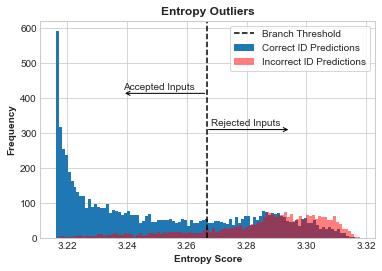

['exit_1']


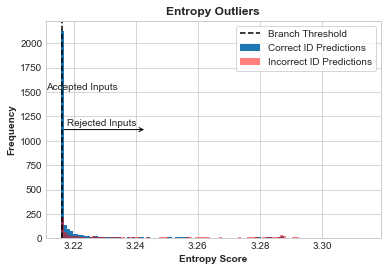

['exit_1', 'exit_2']


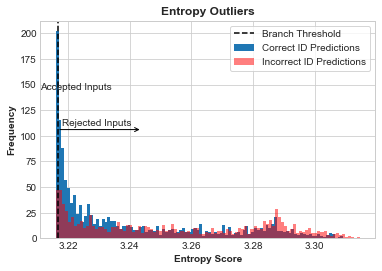

main_exit
   Exit_Name  ID_Inputs  Test_Accuracy Threshold  Accepted_Input  Accepted_Correct  Accepted_Accuracy  Rejected_Input  Accepted %
0     exit_1      10000         0.7144  3.266654            5466              4891           0.894804        0.453400    0.546600
1     exit_2       4534         0.8306  3.216428            2089              1931           0.924366        0.539259    0.460741
2  Main_exit       2445         0.8362        NA            2445              1429           0.584458        0.000000    1.000000


In [25]:

EvaluateID(output_ID,metrics=["entropy"], threshold="gmean", exit=-1, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])

metric:  entropy threshold:  gmean


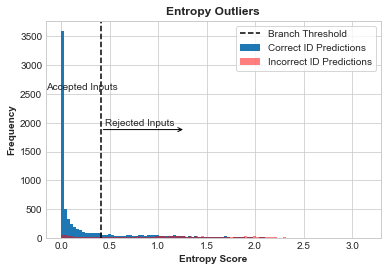

['exit_1']


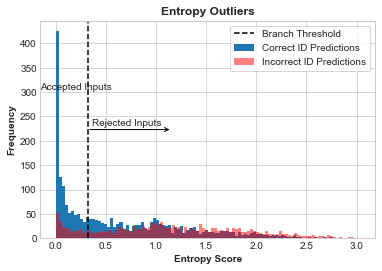

['exit_1', 'exit_2']


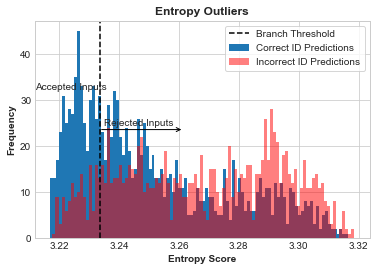

main_exit
   Exit_Name  ID_Inputs  Test_Accuracy Threshold  Accepted_Input  Accepted_Correct  Accepted_Accuracy  Rejected_Input  Accepted %
0     exit_1      10000         0.7839  0.414696            6168              5780           0.937095        0.383200    0.616800
1     exit_2       3832         0.8017   0.32181            1265              1033           0.816601        0.669885    0.330115
2  Main_exit       2567         0.8097        NA            2567              1368           0.532918        0.000000    1.000000


In [65]:
#SD sgd optimizer
EvaluateID(output_ID,metrics=["entropy"], threshold="gmean", exit=-1, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])

In [42]:
def EvaluateOOD(ID,OOD,metrics=["energy"], threshold=None, exit=-1, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1']):
    '''
    Build an evaluation plot of the branched model's performance on ID and OOD datasets.

    ::Variables::
    ID: in-distribution dataset
    OOD: out of distribution dataset
    metrics: list of strings of metrics to evaluate branch results with. can be any of the following: ["gmean", "mean", "PR_AUC"]
    exit: #if a specific exit number is specified, only output the results of that exit. counts from 0 - N, with 0 being the main exit. -1 returns all exits
    legend: specify a legend to use for the plot
    main_exit_included: specify if the last exit must answer all inputs recieved, if False, it will use the threshold to accept and reject inputs
    plot: choose to produce a plot or just the table of branch results
    exit_labels: what labels to use for the exits, defaults to "exit_N" 
    '''
    lessThanMetrics = ["energy","uncert","entropy"]
    if type(metrics) is not list:
        metrics = [metrics]
    for j, metric in enumerate(metrics):
        print("metric: ", metric, "threshold: ",threshold)
        rollOver_ID_indices = pd.Index([])
        rollOver_OOD_indices = pd.Index([])
        Exit_Name=[]
        _ID = ID.copy()
        _OOD = OOD.copy()
        _ID.append(_ID.pop(0))
        _OOD.append(_OOD.pop(0))
        Accepted_df = pd.DataFrame()
        Input_ID=[]
        Input_OOD=[]
        Accepted_list =[]
        Accepted_ID_list = []
        Accepted_OOD_list = []
        Acceptance_correct =[]
        Input_predictions =[]
        Accepted_Ratio_list=[]
        Accepted_Accuracy_list=[]
        Branch_flops = []
        Thresholds=[]
        Test_accuracy =[]
        Rollover_accuracy=[]
        Results=[]
        
        if exit > 0: #if a specific exit number is specified, only output the results of that exit.
            _ID = [_ID[max(exit-1,0)]]
            _OOD = [_OOD[max(exit-1,0)]]
            exit_labels=['exit_{}'.format(exit)]
        for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD)): 
            Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                    print("threshold",_threshold)
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    Correct = output_ID.loc[(output_ID["correct"] == True)]
                    _threshold = np.array(Correct[metric]).mean()
                if _threshold == "gmean":
                    AUC_thresholds = evaluate.calc_AUC(output_ID, metrics=metric, plot = False)
                    _threshold = AUC_thresholds[j]
                if _threshold == "PR_AUC":
                    precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                    _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                else:
                    _threshold = np.float32(_threshold)

            if len(rollOver_ID_indices)>0:
                # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                output_ID = output_ID.iloc[rollOver_ID_indices]
            if len(rollOver_OOD_indices)>0:
                # if plot:
                # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                output_OOD = output_OOD.iloc[rollOver_OOD_indices]
            
            legend = ["Branch Threshold","Correct ID Predictions","Incorrect ID Predictions", "OOD Inputs"]
            Correct = output_ID.loc[(output_ID['correct'] == True)]
            Incorrect = output_ID.loc[(output_ID['correct'] == False)]
            if plot:
                
                _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram

            if plot:
                plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                plt.title(metric.capitalize() + " Outliers", weight="bold")
                # plt.legend(legend)
                plt.xlabel(metric.capitalize() + " Score", weight="bold")
                plt.ylabel("Frequency", weight="bold")
                plt.legend(legend,frameon=True)
                
                ## arrow annotation
                if lessThanMetrics:
                    ymax = plt.gca().get_ylim()
                    xmax = plt.gca().get_xlim()
                    ywidth = abs(ymax[0] - ymax[1])
                    xwidth = abs(xmax[0] - xmax[1])
                    print(ymax, ywidth)
                    print(xmax, _threshold- xmax[1]/10 )
                    
                    plt.text(max(_threshold- xwidth/4,xmax[0]) , (ywidth/1.5) + ywidth/60 ,"Accepted Inputs",wrap=True)
                    plt.annotate("", xy=(_threshold - xwidth/4, ywidth/1.5), xytext=(_threshold, ywidth/1.5), arrowprops=dict(arrowstyle="->"))
                    
                    plt.text(min(_threshold + xwidth/80,xmax[1]), (ywidth/2)+ ywidth/60,"Rejected Inputs",wrap=True)
                    plt.annotate("", xy=(_threshold + xwidth/4, ywidth/2), xytext=(_threshold, ywidth/2),  arrowprops=dict(arrowstyle="->"))
                else:
                    plt.annotate("", xy=(_threshold, 100), xytext=(_threshold, 0), arrowprops=dict(arrowstyle="->"))
                    
                plt.show()
            if main_exit_included and i == len(_ID)-1 :
                Exit_Name.append("Main_exit")
                _threshold
                if plot:
                    print("main_exit")
                OOD_accepted = output_OOD
                OOD_rejected = None
                ID_accepted = output_ID
                ID_rejected = None
                accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                rejected_correct = None
                accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                rejected_incorrect = None
                accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                _threshold = "NA"
            else:
                if metric in lessThanMetrics: ## metrics that require less than metric
                    OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                    OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                    ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                    ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN

                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                else: ### metrics that require greater than metric
                    OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                    OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                    ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                    ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                rollOver_ID_indices = ID_rejected.index
                rollOver_OOD_indices = OOD_rejected.index
                if i >= len(exit_labels):
                    exit_labels.append("exit_{}".format(i+1))
                print(exit_labels)
                Exit_Name.append(exit_labels[i])
            Thresholds.append(_threshold)
            
            Results.append(accepted_correct + accepted_incorrect)
            Input_ID.append(len(output_ID))
            Input_OOD.append(len(output_OOD))
            Accepted_ID_list.append(len(ID_accepted))
            Accepted_OOD_list.append(len(OOD_accepted))
            Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted) + len(OOD_accepted)))
            Acceptance_correct.append(len(accepted_correct))
            Accepted_Accuracy_list.append(overall_accepted_acc)
        df = pd.DataFrame({
        "Exit_Name":Exit_Name,
        "ID_Inputs":Input_ID,
        "OOD_Inputs":Input_OOD,
        "Test_Accuracy":Test_accuracy,
        # "RollOver_Accuracy":Rollover_accuracy,
        "Threshold":Thresholds,
        "Accepted ID":Accepted_ID_list,
        "Accepted OOD":Accepted_OOD_list,
            
        "Accepted_Correct":Acceptance_correct,
        "Accepted_ID_Ratio":Accepted_Ratio_list,
        "Acceptance_Accuracy":Accepted_Accuracy_list,

        # "Flops":Branch_flops,
        # "Cost Ratio":,                                  
                        })
        with pd.option_context('expand_frame_repr', False):
            print (df)

metric:  entropy threshold:  gmean
entropy  lr_auc 0.1978559342150851 Best Threshold=3.2607171535491943, G-Mean=0.730577554374596, TPR=0.7855538922155688, FPR=0.3205513100436681


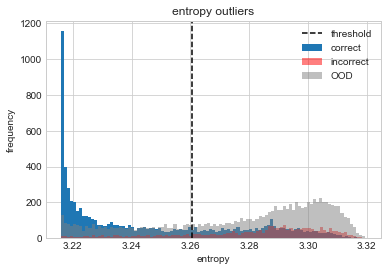

['exit_1']
entropy  lr_auc 0.13364151696606788 Best Threshold=3.218151092529297, G-Mean=0.7949179899703133, TPR=0.8157575757575758, FPR=0.22538922155688623


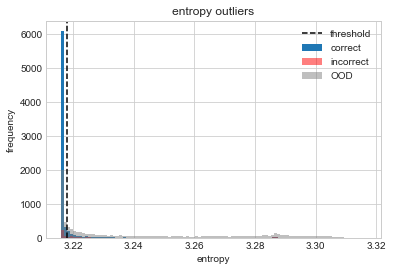

['exit_1', 'exit_2']
entropy  lr_auc 0.1269731080285911 Best Threshold=3.2187793254852295, G-Mean=0.7994873490140446, TPR=0.832345971563981, FPR=0.23207410972088546


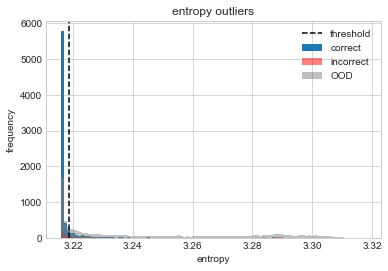

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7328  3.260717         5553          2796              4979           0.665110             0.596359
1     exit_2       4447        7204         0.8350  3.218151         2258          1528              2057           0.596408             0.543317
2  Main_exit       2189        5676         0.8312        NA         2189          5676              1183           0.278322             0.150413


In [53]:
#branching
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.1978559342150851 Best Threshold=3.2607171535491943, G-Mean=0.730577554374596, TPR=0.7855538922155688, FPR=0.3205513100436681


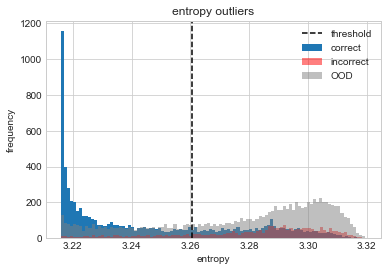

['exit_1']
entropy  lr_auc 0.13364151696606788 Best Threshold=3.218151092529297, G-Mean=0.7949179899703133, TPR=0.8157575757575758, FPR=0.22538922155688623


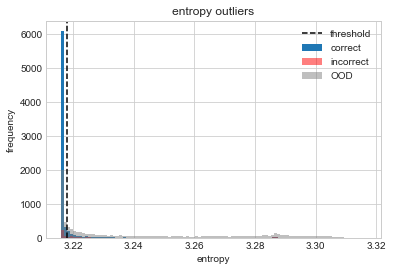

['exit_1', 'exit_2']
entropy  lr_auc 0.1269731080285911 Best Threshold=3.2187793254852295, G-Mean=0.7994873490140446, TPR=0.832345971563981, FPR=0.23207410972088546


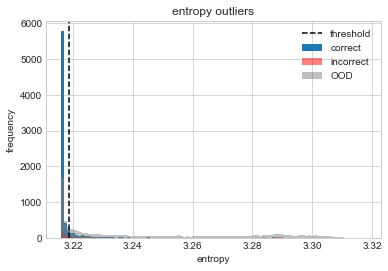

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7328  3.260717         5553          2796              4979           0.665110             0.596359
1     exit_2       4447        7204         0.8350  3.218151         2258          1528              2057           0.596408             0.543317
2  Main_exit       2189        5676         0.8312        NA         2189          5676              1183           0.278322             0.150413


In [51]:
#branching
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.1269731080285911 Best Threshold=3.2187793254852295, G-Mean=0.7994873490140446, TPR=0.832345971563981, FPR=0.23207410972088546


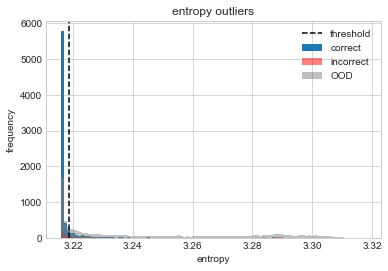

['exit_1']
entropy  lr_auc 0.1978559342150851 Best Threshold=3.2607171535491943, G-Mean=0.730577554374596, TPR=0.7855538922155688, FPR=0.3205513100436681


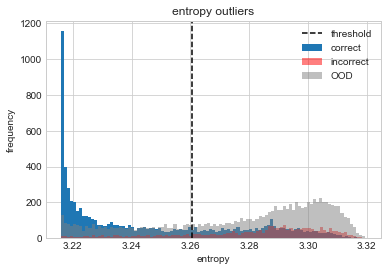

['exit_1', 'exit_2']
entropy  lr_auc 0.13364151696606788 Best Threshold=3.218151092529297, G-Mean=0.7949179899703133, TPR=0.8157575757575758, FPR=0.22538922155688623


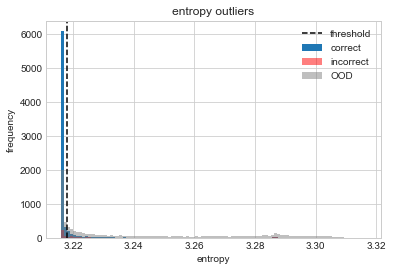

['exit_1', 'exit_2', 'exit_3']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.8312   3.218779         6667          2385              6383           0.736522             0.705148
1    exit_2       3333        7615         0.7328   3.260717         1086          1860               749           0.368635             0.254243
2    exit_3       2247        5755         0.8350   3.218151          221           319               170           0.409259             0.314815


In [27]:
#Baseline
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.1978559342150851 Best Threshold=3.2607171535491943, G-Mean=0.730577554374596, TPR=0.7855538922155688, FPR=0.3205513100436681


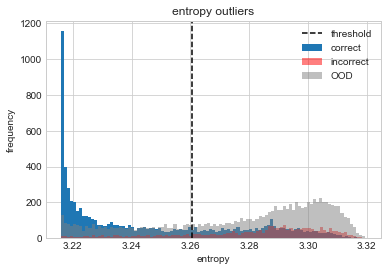

['exit_1']
entropy  lr_auc 0.13364151696606788 Best Threshold=3.218151092529297, G-Mean=0.7949179899703133, TPR=0.8157575757575758, FPR=0.22538922155688623


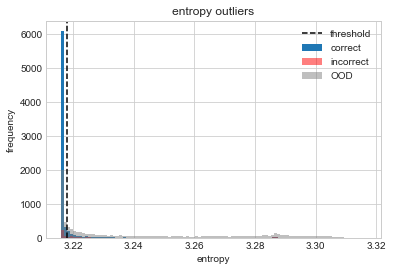

['exit_1', 'exit_2']
entropy  lr_auc 0.1269731080285911 Best Threshold=3.2187793254852295, G-Mean=0.7994873490140446, TPR=0.832345971563981, FPR=0.23207410972088546


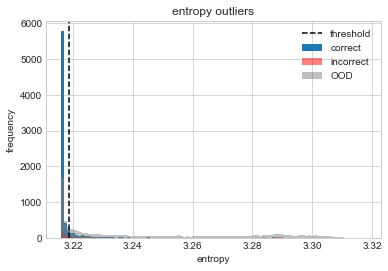

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7328  3.260717         5553          2796              4979           0.665110             0.596359
1     exit_2       4447        7204         0.8350  3.218151         2258          1528              2057           0.596408             0.543317
2  Main_exit       2189        5676         0.8312        NA         2189          5676              1183           0.278322             0.150413


In [20]:
#branching
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True
                                ,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.1341651753210079 Best Threshold=0.21491119265556335, G-Mean=0.7950990161256442, TPR=0.8664804469273742, FPR=0.27040194884287455


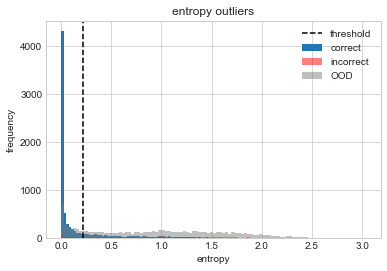

['exit_1']
entropy  lr_auc 0.12005006251371846 Best Threshold=0.02590709738433361, G-Mean=0.8114755626009562, TPR=0.8465473145780051, FPR=0.22214319582740635


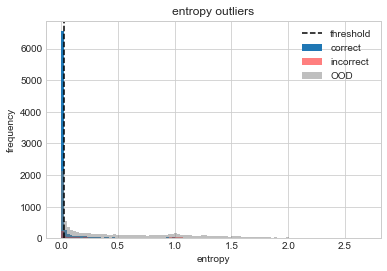

['exit_1', 'exit_2']
entropy  lr_auc 0.11912484109824943 Best Threshold=3.2332911491394043, G-Mean=0.8117346404128742, TPR=0.8481532147742818, FPR=0.2231201686577653


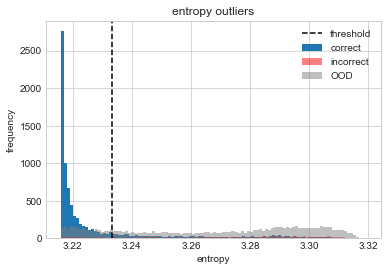

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.8210  0.214911         6230          1978              5990           0.759016             0.729776
1     exit_2       3770        8022         0.8436  0.025907         1211          1045              1063           0.536791             0.471188
2  Main_exit       2559        6977         0.8538        NA         2559          6977              1487           0.268352             0.155935


In [78]:
#BSD
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.19112388096335958 Best Threshold=3.2666544914245605, G-Mean=0.7396169014893824, TPR=0.7990196078431373, FPR=0.31536954087346025


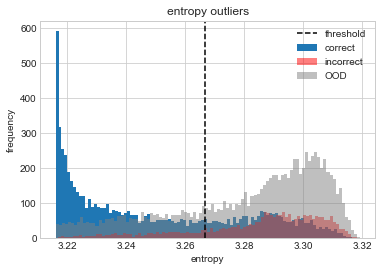

['exit_1']
entropy  lr_auc 0.1334109764324505 Best Threshold=3.216427803039551, G-Mean=0.7954076481384014, TPR=0.8541912632821723, FPR=0.2593306043823742


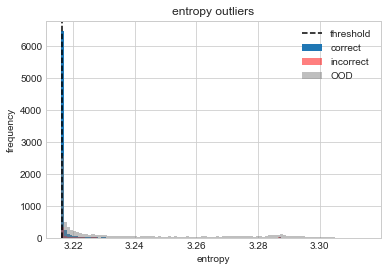

['exit_1', 'exit_2']
entropy  lr_auc 0.13560830596228823 Best Threshold=3.2167882919311523, G-Mean=0.793373837085172, TPR=0.8656898656898657, FPR=0.27290121980387466


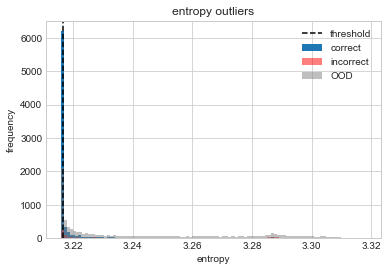

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7144  3.266654         5466          2814              4891           0.660145             0.590700
1     exit_2       4534        7186         0.8306  3.216428         2089          1216              1931           0.632073             0.584266
2  Main_exit       2445        5970         0.8362        NA         2445          5970              1429           0.290553             0.169816


In [69]:
#CE Early stopping, Calibration
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])
